In [1]:
# here we load all packages that are needed in this notebook.
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn import linear_model

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler

#------------------------------------------------------------------------------
#                   Lineaire Regressie  Functies
#------------------------------------------------------------------------------
def model(X, y, degree):
    """ function that models a polynomial"""
    poly_features = PolynomialFeatures(degree=degree, include_bias=False)
    X_poly = poly_features.fit_transform(X)
    lin_reg = LinearRegression()
    lin_reg.fit(X_poly, y)
    print('\nmodel outcome:')
    print(f'intercept: {lin_reg.intercept_} coefficient {lin_reg.coef_}')
    return [lin_reg, poly_features]


def predict(X, model, poly_features, n=1000):
    """ function that predicts y based on a model """
    X_pred=np.linspace(X.min(), X.max(), n).reshape(n, 1)
    X_pred_poly = poly_features.transform(X_pred)
    y_pred = model.predict(X_pred_poly)
    return [X_pred, y_pred]


#4. Plot the points and the regression curve
def plot_polynomial(X,y,X_pred,y_pred):
    """function that plots data and prediction"""
    plt.plot(X, y, "b.", label = 'Data')
    plt.plot(X_pred, y_pred, "r-", linewidth=2, label="model trainset")
    plt.ylabel('Average Temperature')
    plt.xlabel('Year')
    plt.title('Average temperature in the Netherlands -  TRAIN')
    plt.legend()
    plt.show()



In [2]:
#------------------------------------------------------------------------------
#                          Clean
#------------------------------------------------------------------------------
# Read the csv from its location
df = pd.read_csv("data/GlobalLandTemperaturesByCountry.csv", index_col=0, parse_dates=True)

# Select the country (Netherlands), and drop unknown values
df = df.loc[df["Country"]=="Netherlands"]
df.head()

,AverageTemperature,AverageTemperatureUncertainty,Country
dt,,,
1743-11-01,8.009,1.779,Netherlands
1743-12-01,NaN,NaN,Netherlands
1744-01-01,NaN,NaN,Netherlands
1744-02-01,NaN,NaN,Netherlands
1744-03-01,NaN,NaN,Netherlands


In [3]:
df = df.dropna()

# Drop columns we won't use
df = df.drop(["AverageTemperatureUncertainty","Country"], axis=1)

df["Year"] = df.index.year


df.head()

,AverageTemperature,Year
dt,,
1743-11-01,8.009,1743
1744-04-01,8.443,1744
1744-05-01,11.643,1744
1744-06-01,14.773,1744
1744-07-01,16.277,1744


In [4]:
# Take average temperature per year
data = df.groupby(["Year"]).mean()

# And drop years where less than 12 values are known (why do we do this?)
# This selection can be done in a neater way, this generates a warning (but the warning can be ignored in this case)
data = data[df["Year"].value_counts()==12]

data.head()

/var/folders/sh/djdw6j_j1zbfpbcf7k2z77rc0000gp/T/ipykernel_1692/434381446.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data = data[df["Year"].value_counts()==12]


,AverageTemperature
Year,
1753,9.440083
1754,9.111833
1755,8.924750
1756,9.568667
1757,9.436250


/var/folders/sh/djdw6j_j1zbfpbcf7k2z77rc0000gp/T/ipykernel_1692/3608678702.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Year"] = data.index


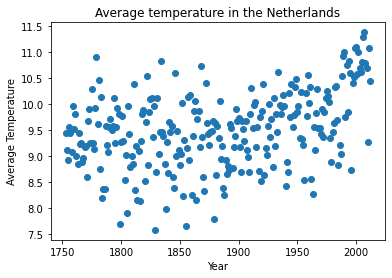

In [5]:
# Plot the data
data["Year"] = data.index
plt.scatter(data["Year"], data["AverageTemperature"])
plt.ylabel('Average Temperature')
plt.xlabel('Year')
plt.title('Average temperature in the Netherlands')
plt.show()



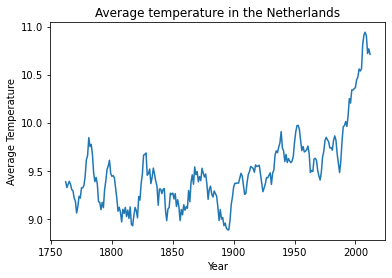

In [6]:
#------------------------------------------------------------------------------
#                         Rolling mean
#------------------------------------------------------------------------------

df = data["AverageTemperature"].rolling(window=10).mean()
df = df.dropna()

#df.to_csv('temperatuur.csv')

y = df.values.reshape(-1,1)
X = df.index.values
X = X.reshape(-1,1)

plt.plot(X,y)
plt.ylabel('Average Temperature')
plt.xlabel('Year')
plt.title('Average temperature in the Netherlands')
plt.show()



In [7]:

#------------------------------------------------------------------------------
#                         Regression
#------------------------------------------------------------------------------
#1. Normalise
scaler = StandardScaler()
scaler = scaler.fit(X)
X = scaler.transform(X)

In [9]:


#2. Split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
print("train and test data are split:")
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

#3. Model
degree = 8
lin_reg, poly_features = model(X_train, y_train, degree)
X_pred, y_pred = predict(X_train, lin_reg, poly_features)



train and test data are split:
(200, 1) (200, 1)
(51, 1) (51, 1)

model outcome:
intercept: [9.19761073] coefficient [[ 0.16002696  1.17795799  0.30556493 -1.65840727 -0.3236207   0.87284898
   0.0905357  -0.14024564]]


In [10]:
#3. Model
degree = 3
lin_reg, poly_features = model(X_train, y_train, degree)
X_pred, y_pred = predict(X_train, lin_reg, poly_features)



model outcome:
intercept: [9.26708662] coefficient [[0.12447822 0.23135511 0.08295869]]


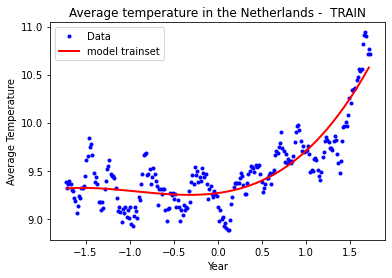

Mean squared error: 0.35


In [11]:

#------------------------------------------------------------------------------
#                         Evaluation
#------------------------------------------------------------------------------

#4. Plot the points and the regression curve
plot_polynomial(X,y,X_pred,y_pred)

#5 calculate mean squared error from test set
X_pred, y_pred = predict(X_test, lin_reg, poly_features, len(y_test))
print('Mean squared error: {:.2f}'.format(mean_squared_error(y_test, y_pred)))